<a href="https://colab.research.google.com/github/Riku-KANO/basic-ml-model/blob/main/optimization/TPE_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree-structured Parzen Estimatorによるベイズ最適化
under construction

## Tree structured Parzen Estimator (TPE) とは

## Tree structured Parzen Estimator (TPE) の原理


### 問題設定
　まず初めに、問題設定は以下のように設定する。
$$
\newcommand{\argmin}{\mathop{\rm arg~min}\limits}
x^{+}=\argmin_{x∈ℋ} f(x)\\ 
$$

$ℋ$は入力$x$の空間、$f(x)$はブラックボックス関数、$x^{+}$はブラックボックスが出力する最小値の時の入力$x^{+}$である。我々の目標はブラックボックスが最小値を示す時の入力$x^{+}$を求めることを念頭に置いて議論を進めていく。  

### 原理
ベイズ最適化において、TPEはガウス過程回帰と同様にEIやPIなどといった獲得関数を計算する。獲得関数を計算する際、ガウス過程回帰は$p(y|x)$をベースとして以下の数式が最大になる$x$を次の探索候補点$x^*$とする。  
<br>
$$\text{EI}_{y^*}(x)=𝔼[\max(y^{*}-y, 0)]=∫^{∞}_{-∞}\max(y^{*}-y, 0)p_M(y|x)dy$$
<br>
ここで、$y^*$は閾値(threshold)であり、多くの場合では今まで得られた中での$y$の最大値が用いられる。また、$p_M(y|x)$はガウス過程モデルが推定する尤度である。
<br>
　一方でTPEでは$p(x|y)$や$p(y)$を用いて獲得関数を計算する(実際には$p(y)$をモデリングすることはないので実質的には$p(x|y)$のみを考えていくことになる)。TPEでは$p(x|y)$は以下のように定義される。  
<br>
\begin{equation}
  p(x|y)=
  \begin{cases}
    l(x) & \text{if} \ y\lt y^{*}, \\
    g(x) & \text{if} \ y\ge y^{*}, \\
  \end{cases}
\end{equation}
<br>
$l(x)$と$g(x)$は（カーネル）密度であり、$y^{*}$は閾値(threshold)である。$y^{*}$を基準としてそれを超える、またはそれを超えないデータの密度を計算(推定)している。そのデータの推定密度を用いて事後確率を計算している。$y^{*}$の選択方法に関しては$\gamma=p(y<y^{*})$となるような$y^{*}$を選択する。$\gamma$は0から1の間の値をとる実数であり、$\gamma=0.5$とした場合はデータが半々になるような$y^{*}$を選択することを指す。つまり$\gamma$は分位値(quantile)である。  
　以上を踏まえると獲得関数は以下のように記述される。  
<br>
$$\text{EI}_{y^{*}}(x)=\int^{y^{*}}_{-∞}(y^{*}-y)p(y|x)dy=\int^{y^{*}}_{-∞}(y^{*}-y)\frac{p(x|y)p(y)}{p(x)}dy$$
<br>
ここで、  
<br>
$$p(x)=\int_{ℝ}p(x|y)p(y)dy=\gamma l(x)+(1-\gamma)g(x)$$
<br>
であり、
<br>
$$\int^{y^{*}}_{-∞}(y^{*}-y)p(x|y)p(y)dy=l(x)\int^{y^{*}}_{-∞}(y^{*}-y)p(y)dy=\gamma y^{*}l(x)-l(x) \int^{y^{*}}_{-∞}p(y)dy$$
<br>
であるので、これらの２式を上式の獲得関数の式に代入すると、以下の式が得られる。  
<br>
$$\text{EI}_{y^{*}}(x)=\frac{\gamma y^{*}l(x)-l(x)\int^{y^{*}}_{-∞}p(y)dy}{\gamma l(x)+(1-\gamma)g(x)}∝\left(\gamma + \frac{g(x)}{l(x)}(1-\gamma)\right)^{-1}$$
<br>
この式から、獲得関数が$g(x)/l(x)$のみに依存しているということがわかる。

## カーネル密度推定
カーネル密度推定はここではsklearnを用いて行うことにする。

### カーネル密度推定とは
カーネル密度推定とはデータの分布をノンパラメトリックに分布を予測する手法である。正規分布や二項分布はパラメトリックモデルと呼ばれているのは、その分布が複数のパラメータのみによって記述されるからである。ノンパラメトリックモデルでは分布を支配するパラメータの存在を仮定しない。  
具体的には$i$番目のデータを$X_i$として表すと以下の式で分布$p$を推定する。
$$\hat{p}=\frac{1}{nh}\sum_{i=1}^{n}K\left(\frac{x-X_i}{h}\right)$$
ここで$K$はカーネル関数, $h$はバンド幅である。この式が意味するように、今まで取得してきたデータ点$X_i$の個数だけカーネル関数を足し合わせることを行う。この処理のイメージとしては、データ点$X_i$の周りに山を作成し、それらを重ね合わせて１つの山($\hat{p}$)を作るイメージとなる。

### カーネルの種類
sklearnで利用できるカーネルの種類は全部で６種類ある。カーネルの形状は次のコードに図示されている。

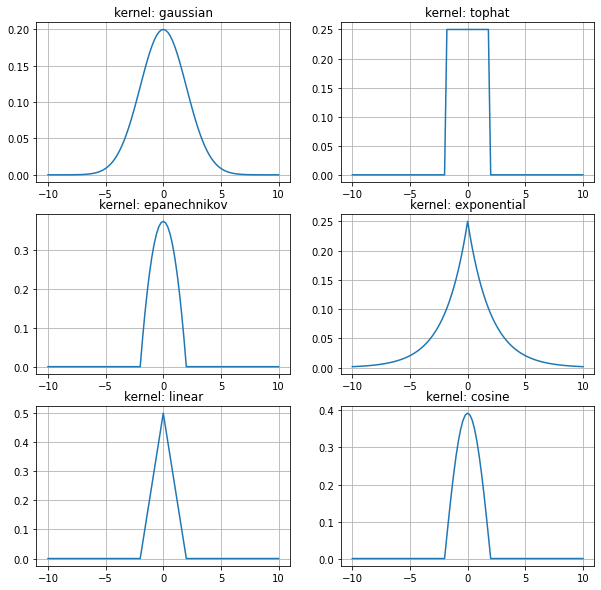

In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
x = np.linspace(-10, 10, 101)
fig, ax=plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
for i, kernel in enumerate(kernels):
    model = KernelDensity(bandwidth=2, kernel=kernel)
    model.fit([[0]])
    ax[i//2, i%2].plot(x, np.exp(model.score_samples(x.reshape(-1, 1))))
    ax[i//2, i%2].set_title(f"kernel: {kernel}")
    ax[i//2, i%2].grid(True)
  
plt.show()

現時点で得られているデータが$x=-3, 0, 3$であり、バンド幅が2であるとすると以下のようにカーネル密度推定が行われる。

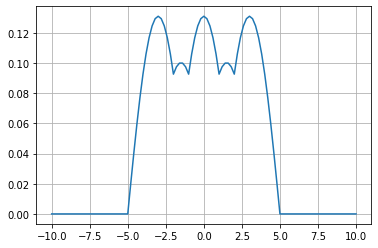

In [2]:
model = KernelDensity(bandwidth=2, kernel=kernel)
model.fit([[0], [-3], [3]])
plt.plot(x, np.exp(model.score_samples(x.reshape(-1, 1))))
plt.grid(True)
plt.show()

## 最適化

In [51]:
GAMMA=0.2
SEED = 42
N_LOOP = 190
N_SUGGEST=30
KERNEL = "gaussian"

DEBUG=True

作成途中  
under construction  
形だけが完成、正常に動作するかは未確認  
2022/09/15  
scipy.stats.gaussian_kernelを使って実装してみたがバンド幅が広すぎる印象がある。また、カーネルの重みを調整する必要があるかもしれない。

In [52]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy import stats

class Sampler:
    def __init__(self, init_data_x, init_data_y, n_suggest, gamma, rng, kernel):
        self.data_x = init_data_x
        self.data_y = init_data_y
        self.n_suggest = n_suggest
        self.gamma = gamma
        self.rng = rng
        self.kernel = kernel
        self.best = np.argmin(self.data_y)
        self.best_id = np.argmin(self.data_y)

    def sample(self, start, end):
        next_x = self.rng.rand(self.n_suggest) * (end-start) + start 
        EIs = self.calc_EI(next_x, start, end)
        next_idx = np.argmax(EIs)
        self.data_x = np.append(self.data_x, next_x[next_idx])
        return next_x[next_idx]

    def calc_EI(self, x: np.ndarray,  start, end):
        return np.reciprocal(self.gamma + self.calc_parzen_estimator(x, start, end) * (1 - self.gamma))

    def calc_parzen_estimator(self, x: np.ndarray, start, end):
        data = np.hstack([self.data_x.reshape(-1, 1), self.data_y.reshape(-1, 1)])
        data = data[np.argsort(data[:, -1])] # yの値でsort
        # kde_g = KernelDensity(bandwidth=2, kernel=self.kernel)
        # kde_l = KernelDensity(bandwidth=2, kernel=self.kernel)
        # kde_g.fit(data[:, :-1])
        # kde_l.fit(data[:, :-1])
        border_id = int(self.gamma * data.shape[0])
        x_g = np.sort(data[:border_id, :-1].ravel())
        x_l = np.sort(data[border_id:, :-1].ravel())
        kde_g = stats.gaussian_kde(x_g)
        kde_l = stats.gaussian_kde(x_l)
        g = kde_g(x)
        # g = kde_g.score_samples(x.reshape(-1, 1))
        l = kde_l(x)
        # l = kde_l.score_samples(x.reshape(-1, 1))
        if DEBUG:
            xargs = np.linspace(start, end, 101)
            plt.plot(xargs, kde_g(xargs), label="g")
            plt.plot(xargs, kde_l(xargs), label="l")
            plt.legend()
            plt.show()
        return g * np.reciprocal(l)

    def update(self):
        self.best = np.min(self.data_y)
        self.best_id = np.argmin(self.data_y)

class TPE:
    def __init__(
        self, 
        data_x=None,
        data_y=None,
        seed=None,
        gamma=0.5,
        n_suggest=30,
        n_trial = 10, 
        objective=None,
        kernel = "gaussian",
        ):
        self.data_x = data_x
        self.data_y = data_y
        self.rng = np.random.RandomState(seed=seed)
        self.gamma = gamma
        self.n_suggest = n_suggest
        self.n_trial = n_trial
        self.parameter_space = None
        self.objective = objective
        self.kernel = kernel
        self.sampler = Sampler(self.data_x, self.data_y, self.n_suggest, self.gamma, self.rng, self.kernel)
        self.history = []

    def search(self):
        for i in range(self.n_trial):
            print(f"[TRIAL: {i+1:04d}]##########")
            score = self.objective(self.sampler)
            self.history.append(score)
            self.sampler.data_y = np.append(self.sampler.data_y, score)
            self.sampler.update()
            print(score)
            print("best trial is {}".format(self.sampler.best_id))
            # print(self.sampler.data_y)


def objective(sampler):
    x = sampler.sample(-10, 10)
    return x**4 / 1000  + x ** 3 / 1000 - x ** 2 / 10 - x / 100 - 0.1 * np.random.rand()

def BBF(x):
    if "__len__" in dir(x):
        return x** 4 / 1000 + x ** 3 / 1000 - x ** 2 / 10 - x / 100 - 0.1 * np.random.rand(len(x))
    else:
        return x** 4 / 1000 + x ** 3 / 1000 - x ** 2 / 10 - x / 100 - 0.1 * np.random.rand()


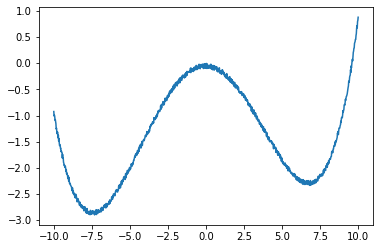

In [17]:
xargs = np.linspace(-10, 10, 1001)
y = BBF(xargs)
plt.plot(xargs, y)

[-10  -8  -6  -4  -2   0   2   4   6   8]
[TRIAL: 0001]##########


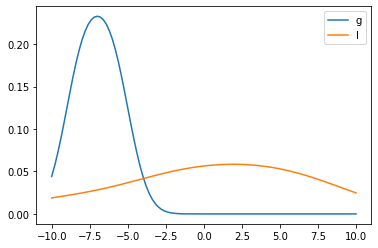

-0.8827020639687683
best trial is 1
[TRIAL: 0002]##########


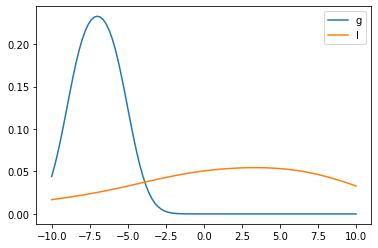

-1.0268544166998856
best trial is 1
[TRIAL: 0003]##########


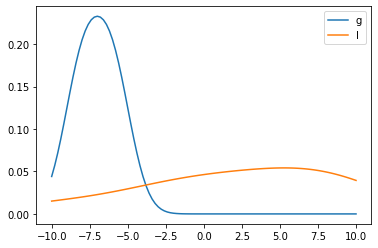

-2.3189138806440206
best trial is 1
[TRIAL: 0004]##########


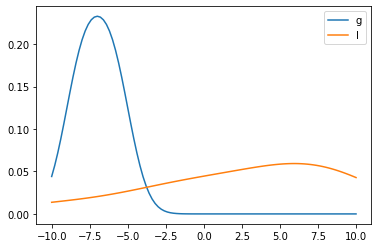

-1.9118266662742882
best trial is 1
[TRIAL: 0005]##########


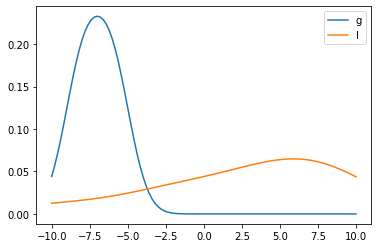

-2.1985476969919615
best trial is 1
[TRIAL: 0006]##########


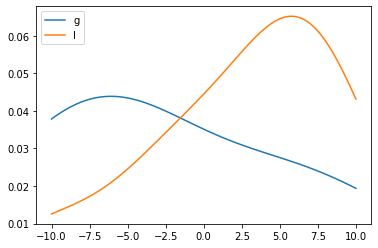

-2.2585326918695996
best trial is 1
[TRIAL: 0007]##########


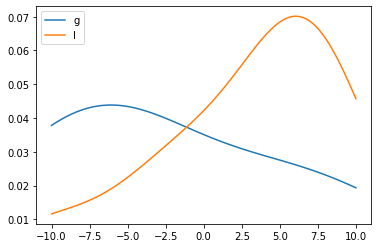

-2.127714374653041
best trial is 1
[TRIAL: 0008]##########


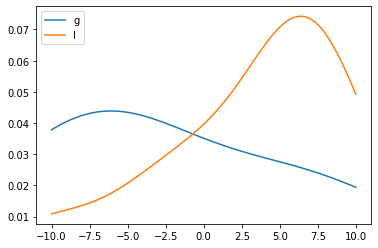

-2.017027932154593
best trial is 1
[TRIAL: 0009]##########


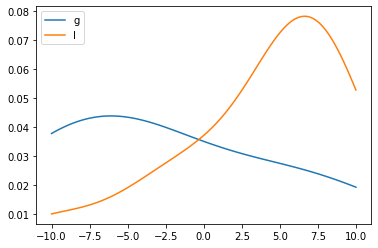

-2.1402344865266456
best trial is 1
[TRIAL: 0010]##########


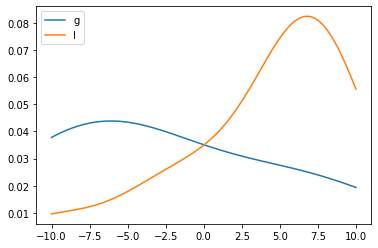

-2.015010746411469
best trial is 1
[TRIAL: 0011]##########


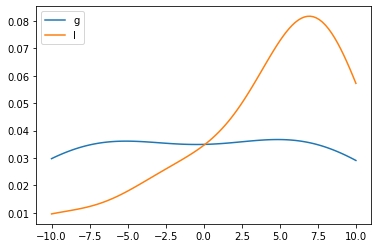

-2.3014778651491428
best trial is 1
[TRIAL: 0012]##########


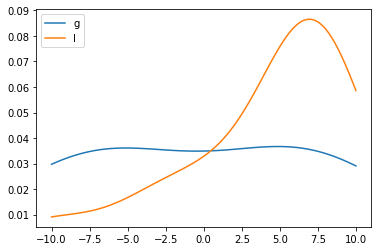

-2.2221156823854997
best trial is 1
[TRIAL: 0013]##########


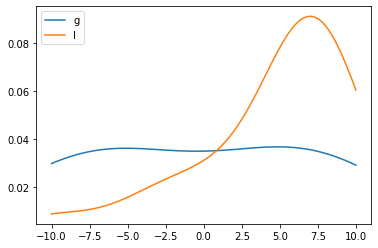

-2.12551899039828
best trial is 1
[TRIAL: 0014]##########


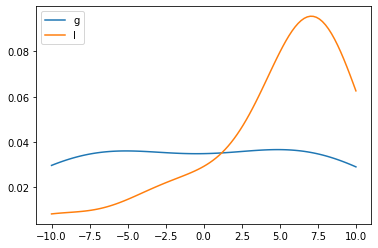

-1.962598016674969
best trial is 1
[TRIAL: 0015]##########


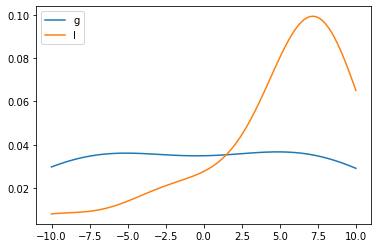

-2.0543951529468876
best trial is 1
[TRIAL: 0016]##########


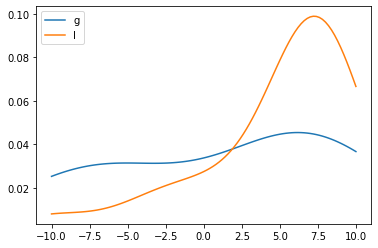

-2.052632444779737
best trial is 1
[TRIAL: 0017]##########


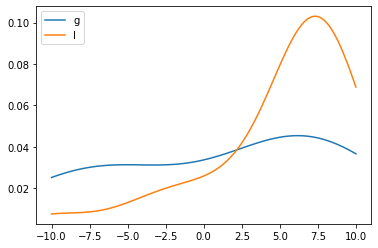

-2.0032073090200826
best trial is 1
[TRIAL: 0018]##########


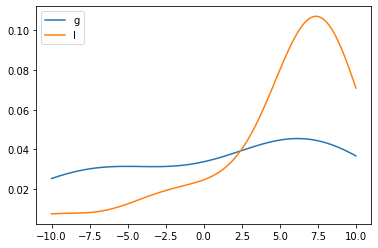

-2.2192396344445386
best trial is 1
[TRIAL: 0019]##########


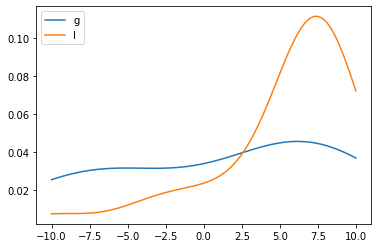

-2.161567258138404
best trial is 1
[TRIAL: 0020]##########


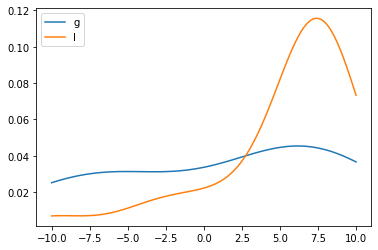

-1.9158490814172984
best trial is 1
[TRIAL: 0021]##########


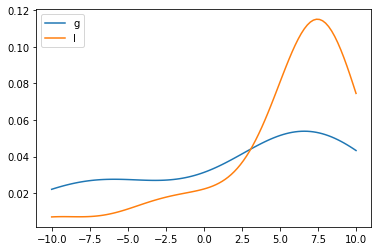

-2.1844506125784866
best trial is 1
[TRIAL: 0022]##########


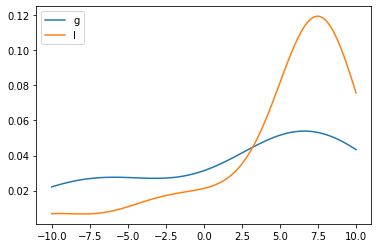

-1.997576756428479
best trial is 1
[TRIAL: 0023]##########


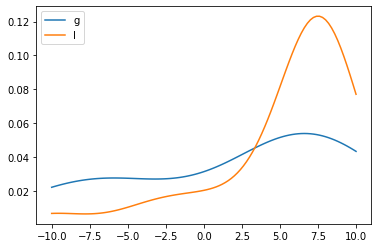

-1.917980748422351
best trial is 1
[TRIAL: 0024]##########


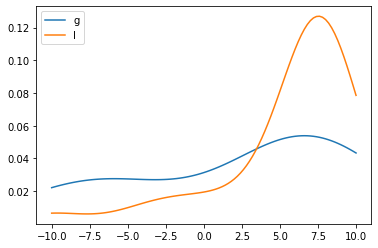

-1.4804753205055308
best trial is 1
[TRIAL: 0025]##########


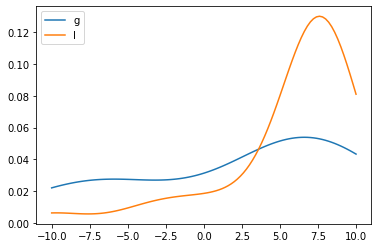

-1.9739013026607632
best trial is 1
[TRIAL: 0026]##########


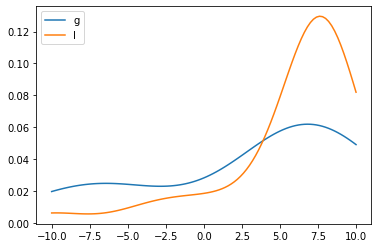

-2.0252576808379916
best trial is 1
[TRIAL: 0027]##########


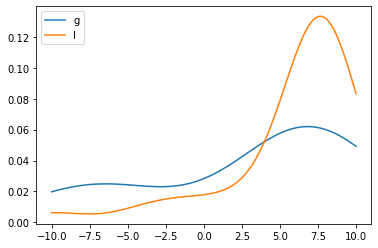

-1.787026214942818
best trial is 1
[TRIAL: 0028]##########


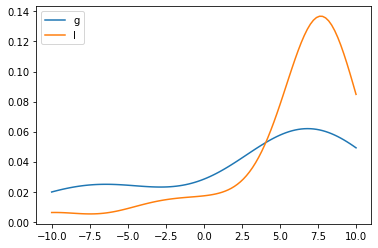

-1.6666838890754663
best trial is 1
[TRIAL: 0029]##########


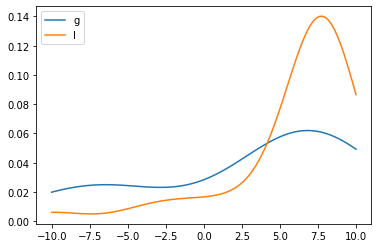

-1.9644747887661527
best trial is 1
[TRIAL: 0030]##########


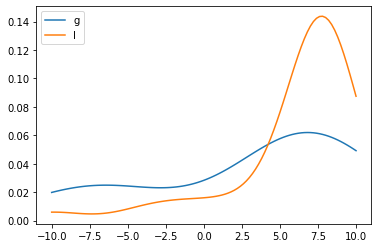

-1.960542783911426
best trial is 1
[TRIAL: 0031]##########


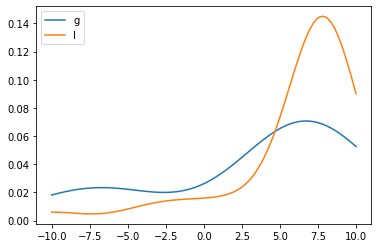

-1.949231949124016
best trial is 1
[TRIAL: 0032]##########


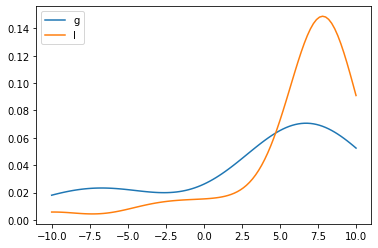

-1.7153852795495856
best trial is 1
[TRIAL: 0033]##########


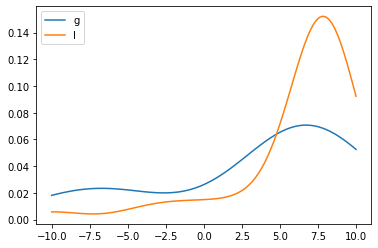

-1.2307889781064891
best trial is 1
[TRIAL: 0034]##########


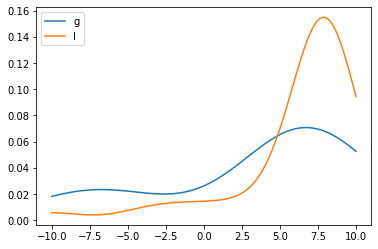

-1.737235282257866
best trial is 1
[TRIAL: 0035]##########


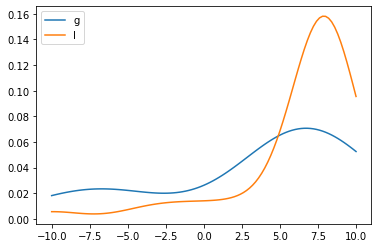

-1.5132705021563573
best trial is 1
[TRIAL: 0036]##########


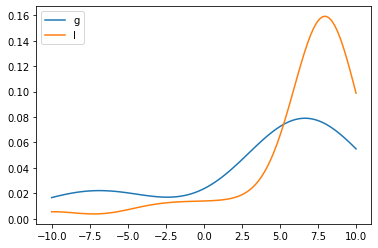

-1.2418462700905488
best trial is 1
[TRIAL: 0037]##########


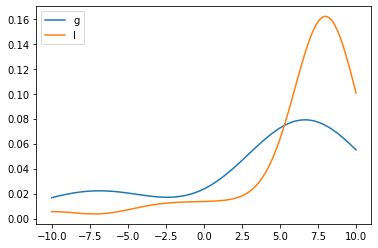

-1.452867246014905
best trial is 1
[TRIAL: 0038]##########


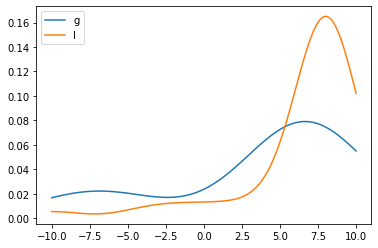

-0.7941993927816122
best trial is 1
[TRIAL: 0039]##########


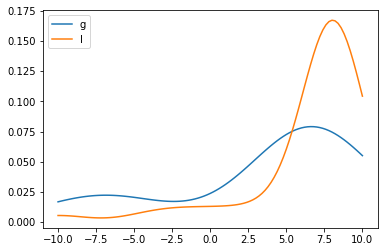

-2.124443705365478
best trial is 1
[TRIAL: 0040]##########


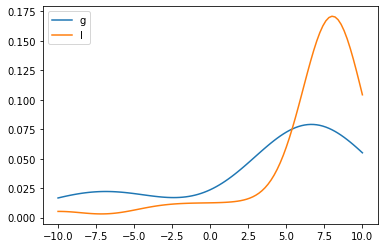

-1.351710884311544
best trial is 1
[TRIAL: 0041]##########


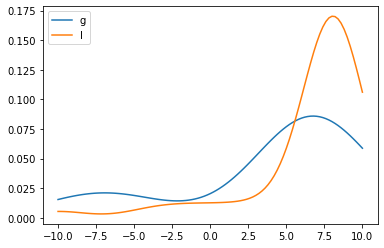

-1.1625447181668116
best trial is 1
[TRIAL: 0042]##########


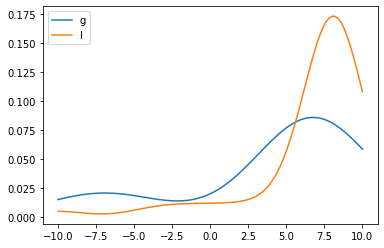

-1.6308612734960644
best trial is 1
[TRIAL: 0043]##########


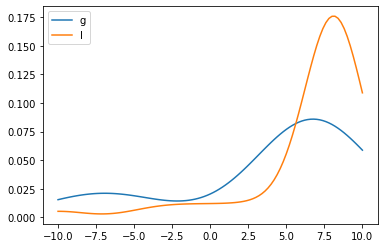

0.23213566687059167
best trial is 1
[TRIAL: 0044]##########


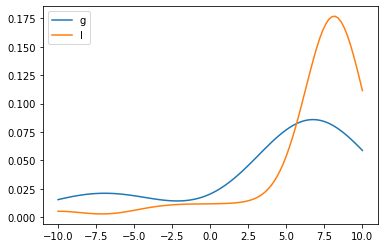

-1.3308415135714735
best trial is 1
[TRIAL: 0045]##########


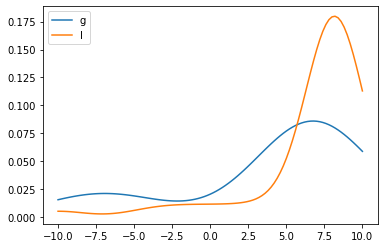

-0.18475028697937323
best trial is 1
[TRIAL: 0046]##########


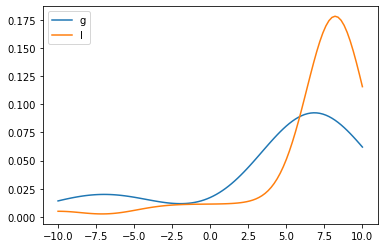

-1.789075227108054
best trial is 1
[TRIAL: 0047]##########


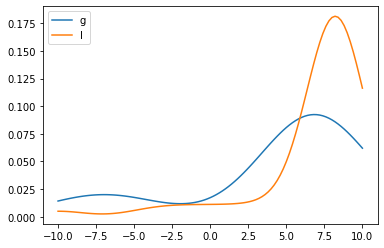

-0.3206630616722392
best trial is 1
[TRIAL: 0048]##########


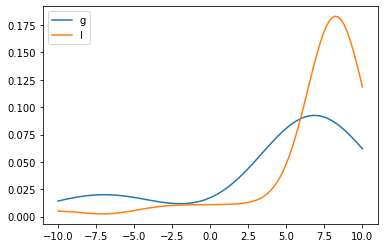

-1.252044742220244
best trial is 1
[TRIAL: 0049]##########


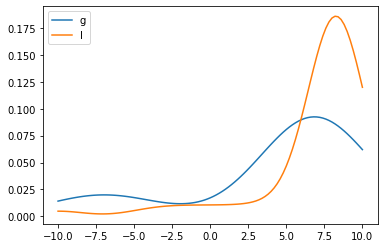

-1.0450852993872812
best trial is 1
[TRIAL: 0050]##########


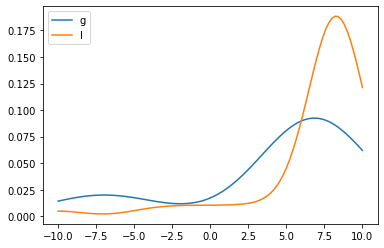

-2.1209541173560207
best trial is 1
[TRIAL: 0051]##########


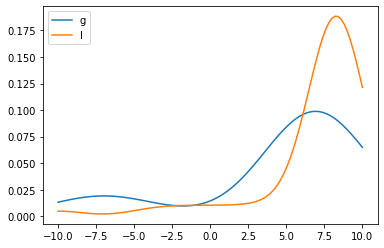

-1.3198727130944112
best trial is 1
[TRIAL: 0052]##########


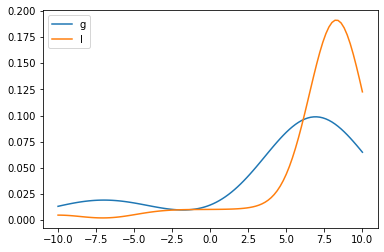

-0.8889465719498442
best trial is 1
[TRIAL: 0053]##########


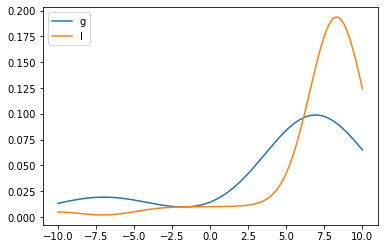

0.28873794045028317
best trial is 1
[TRIAL: 0054]##########


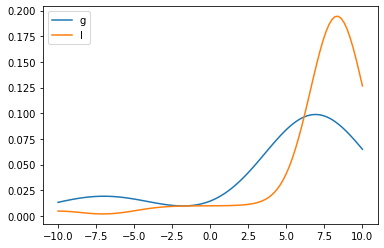

0.47983985206149554
best trial is 1
[TRIAL: 0055]##########


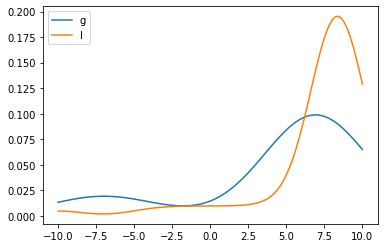

-0.7126259479820506
best trial is 1
[TRIAL: 0056]##########


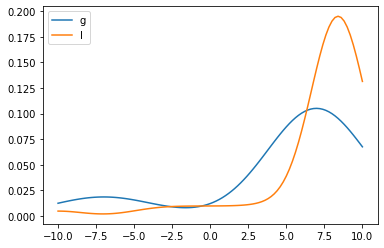

-1.278699323333485
best trial is 1
[TRIAL: 0057]##########


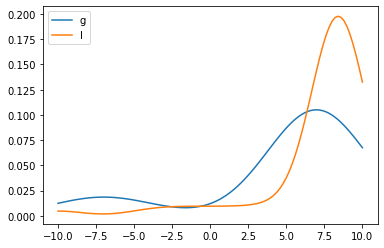

-0.5311588212894093
best trial is 1
[TRIAL: 0058]##########


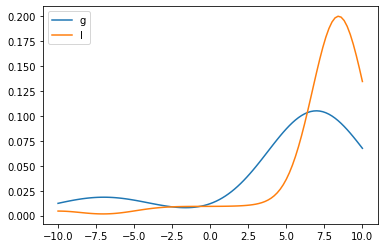

0.12733245608100824
best trial is 1
[TRIAL: 0059]##########


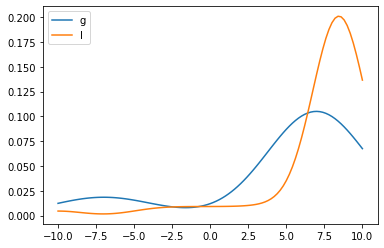

-0.6336650380522478
best trial is 1
[TRIAL: 0060]##########


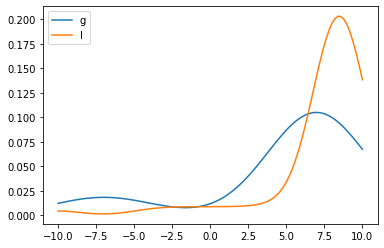

-0.8500123767228313
best trial is 1
[TRIAL: 0061]##########


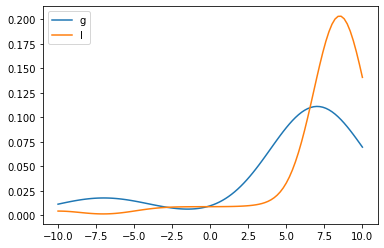

-0.7947524201701941
best trial is 1
[TRIAL: 0062]##########


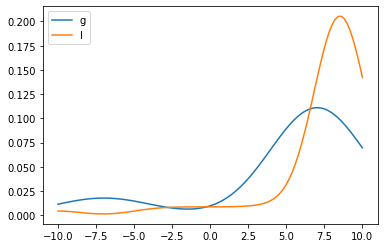

-1.0988630092006417
best trial is 1
[TRIAL: 0063]##########


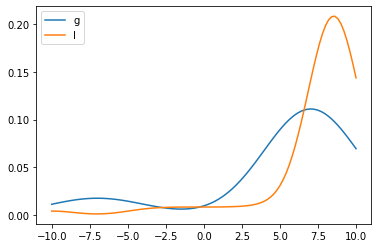

-1.2151350696486398
best trial is 1
[TRIAL: 0064]##########


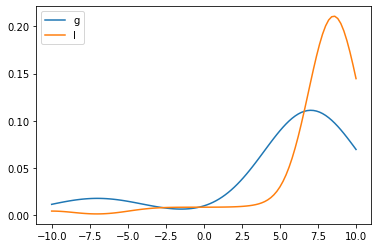

-0.7527992883359391
best trial is 1
[TRIAL: 0065]##########


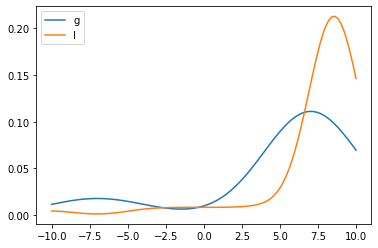

-0.23089291719851907
best trial is 1
[TRIAL: 0066]##########


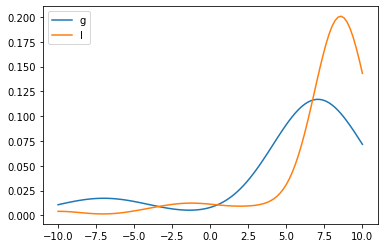

-0.2556257038192335
best trial is 1
[TRIAL: 0067]##########


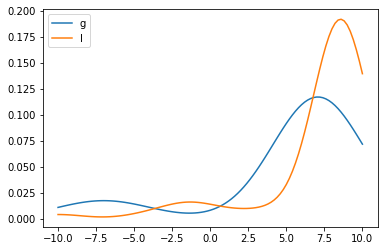

-0.223480705904007
best trial is 1
[TRIAL: 0068]##########


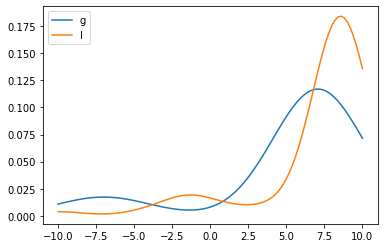

-0.25227024433261674
best trial is 1
[TRIAL: 0069]##########


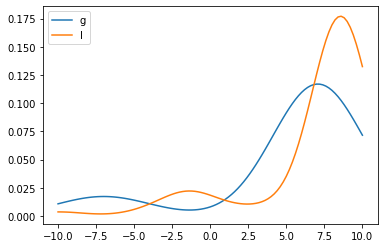

-0.3254101426178304
best trial is 1
[TRIAL: 0070]##########


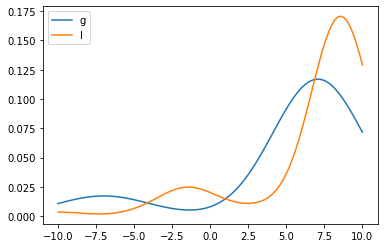

-0.09696182604847325
best trial is 1
[TRIAL: 0071]##########


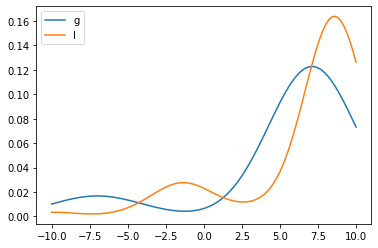

-0.21649775823319817
best trial is 1
[TRIAL: 0072]##########


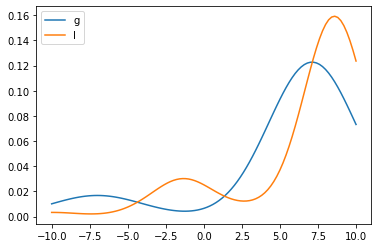

-0.15100789307977752
best trial is 1
[TRIAL: 0073]##########


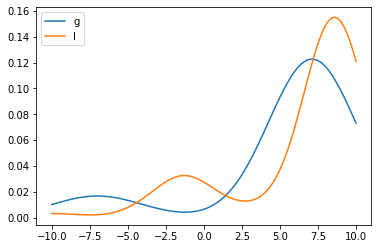

-0.06040493050907675
best trial is 1
[TRIAL: 0074]##########


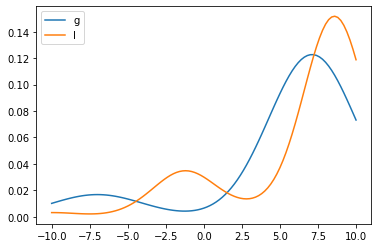

-0.10782164384820192
best trial is 1
[TRIAL: 0075]##########


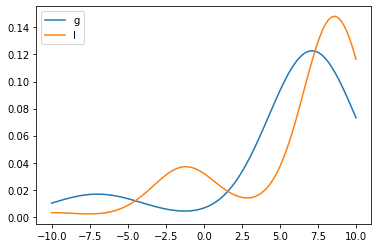

-0.06396090700985113
best trial is 1
[TRIAL: 0076]##########


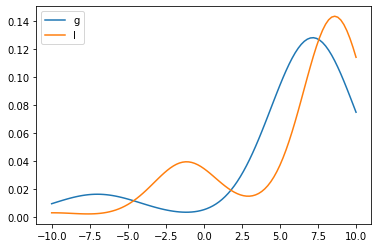

-0.1492349871174752
best trial is 1
[TRIAL: 0077]##########


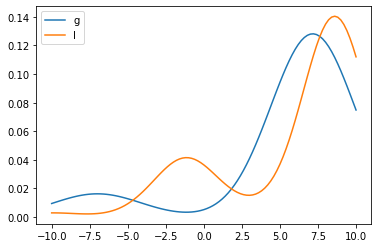

-0.09779881049586817
best trial is 1
[TRIAL: 0078]##########


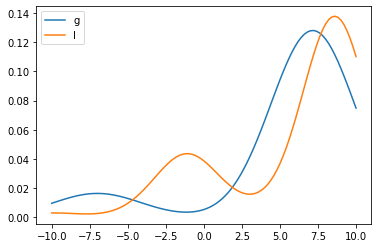

-0.13169641166274898
best trial is 1
[TRIAL: 0079]##########


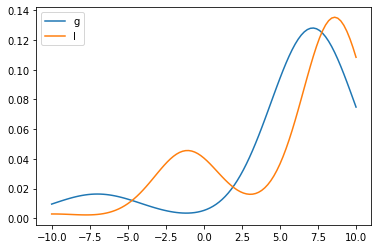

-0.31415379514935715
best trial is 1
[TRIAL: 0080]##########


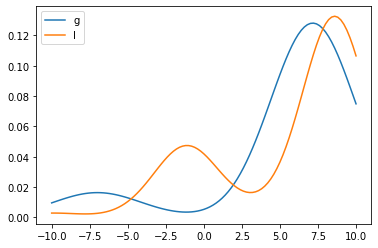

-0.15125200326757296
best trial is 1
[TRIAL: 0081]##########


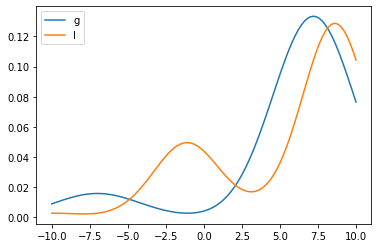

-0.08745609663569756
best trial is 1
[TRIAL: 0082]##########


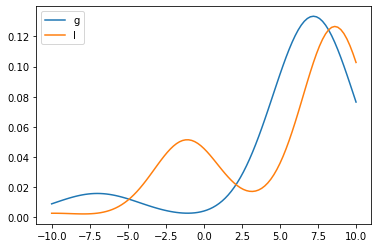

-0.18521033856750319
best trial is 1
[TRIAL: 0083]##########


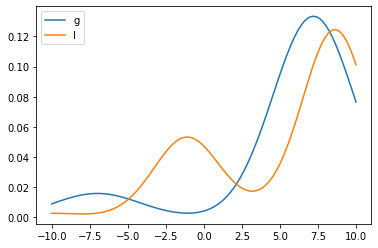

-0.12444349912392554
best trial is 1
[TRIAL: 0084]##########


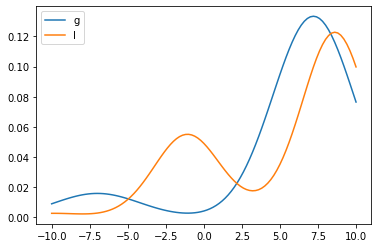

-0.15259120749609864
best trial is 1
[TRIAL: 0085]##########


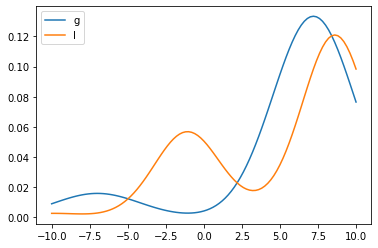

-0.3951680363702622
best trial is 1
[TRIAL: 0086]##########


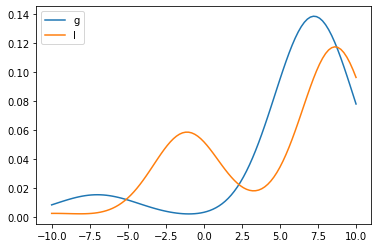

-0.06693091953196222
best trial is 1
[TRIAL: 0087]##########


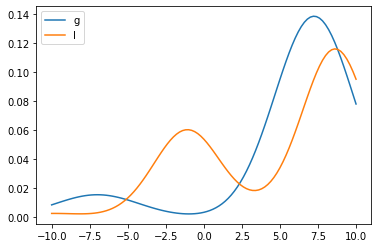

-0.1447476574149982
best trial is 1
[TRIAL: 0088]##########


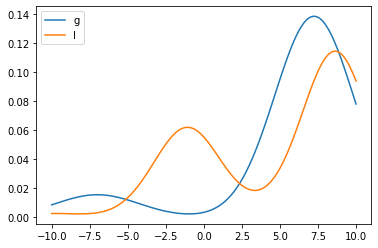

-0.20397236060231097
best trial is 1
[TRIAL: 0089]##########


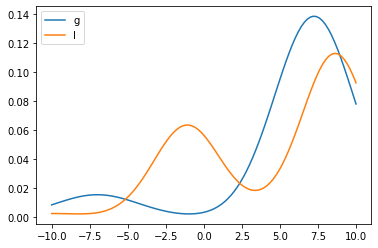

-0.0657480140263674
best trial is 1
[TRIAL: 0090]##########


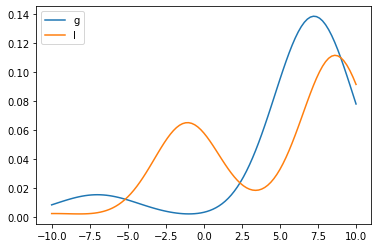

-0.05527886519369368
best trial is 1
[TRIAL: 0091]##########


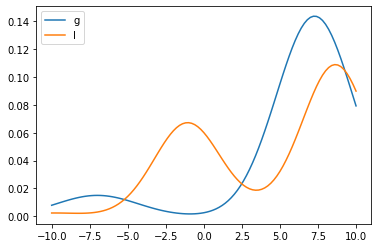

-0.0654111319188808
best trial is 1
[TRIAL: 0092]##########


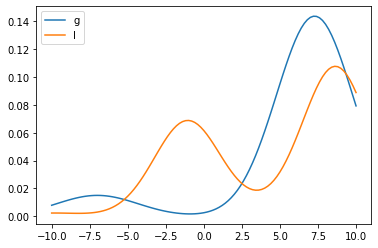

-0.09375330734608228
best trial is 1
[TRIAL: 0093]##########


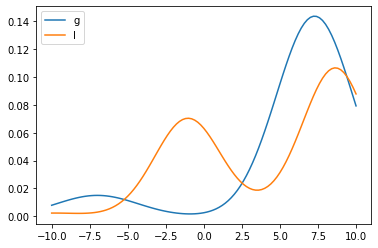

-0.13043976555477022
best trial is 1
[TRIAL: 0094]##########


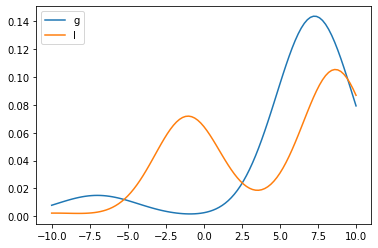

-0.19651661887084468
best trial is 1
[TRIAL: 0095]##########


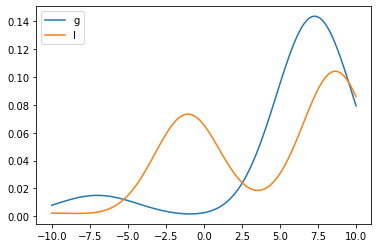

-0.27859805841578494
best trial is 1
[TRIAL: 0096]##########


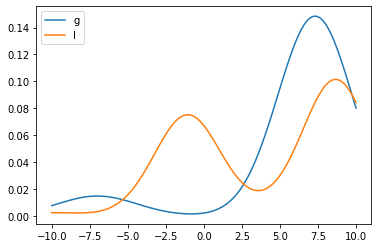

-0.1724170662010962
best trial is 1
[TRIAL: 0097]##########


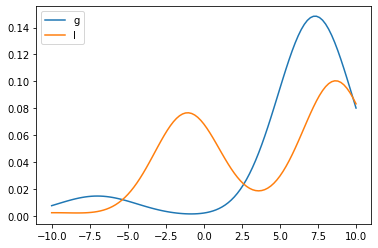

-0.2480600175706658
best trial is 1
[TRIAL: 0098]##########


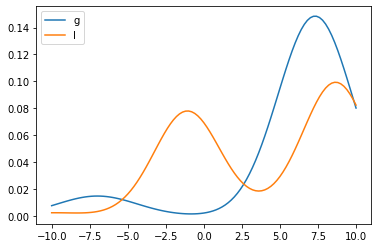

-0.29750226842142546
best trial is 1
[TRIAL: 0099]##########


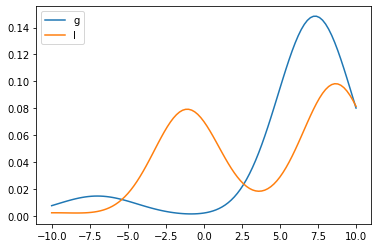

-0.07395437558315579
best trial is 1
[TRIAL: 0100]##########


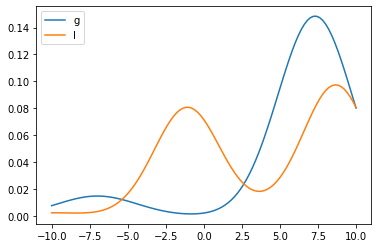

-0.15019640027564055
best trial is 1
[TRIAL: 0101]##########


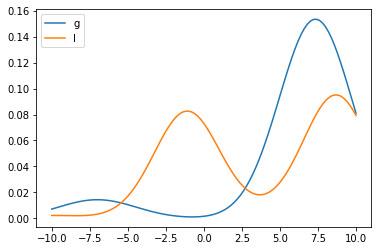

-0.1955022402567792
best trial is 1
[TRIAL: 0102]##########


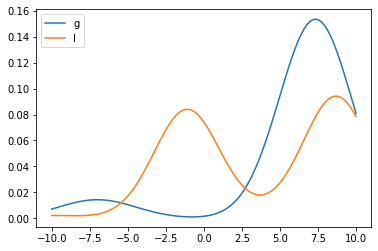

-0.024261932918424028
best trial is 1
[TRIAL: 0103]##########


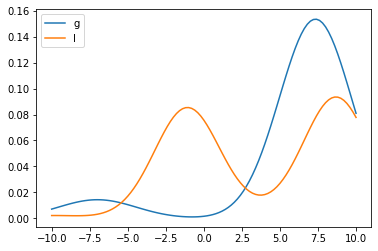

-0.40685644252294073
best trial is 1
[TRIAL: 0104]##########


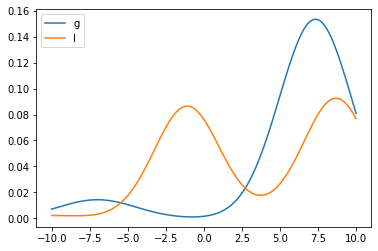

-0.16985349600480737
best trial is 1
[TRIAL: 0105]##########


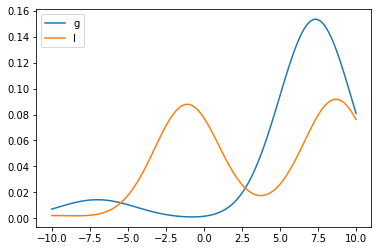

-0.12266274609055489
best trial is 1
[TRIAL: 0106]##########


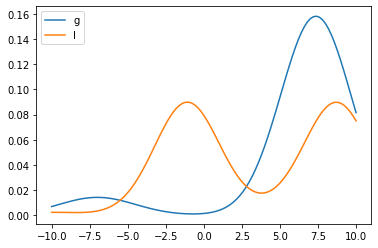

-0.20155946037453754
best trial is 1
[TRIAL: 0107]##########


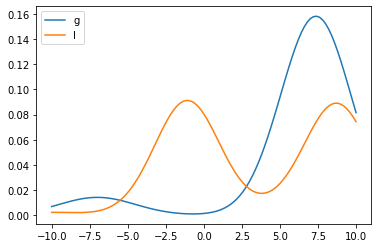

-0.2156355742379746
best trial is 1
[TRIAL: 0108]##########


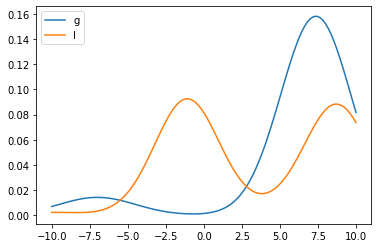

-0.030529274777665993
best trial is 1
[TRIAL: 0109]##########


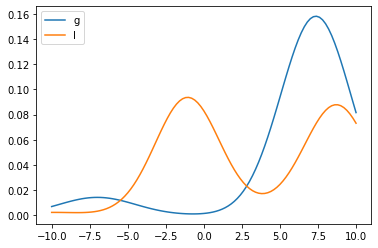

-0.11068528337843515
best trial is 1
[TRIAL: 0110]##########


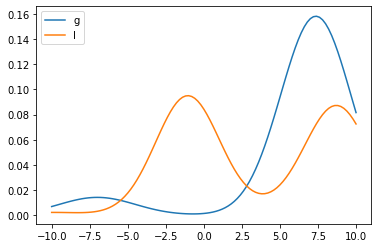

-0.09269726503959735
best trial is 1
[TRIAL: 0111]##########


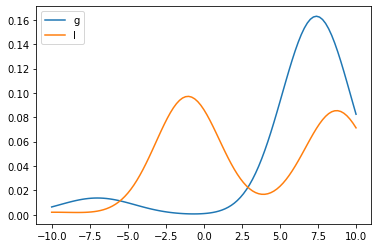

-0.12485124954084066
best trial is 1
[TRIAL: 0112]##########


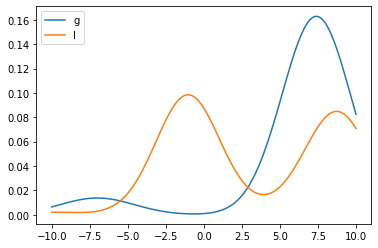

-0.11166536806402455
best trial is 1
[TRIAL: 0113]##########


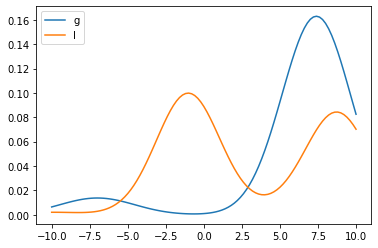

-0.20047626743826055
best trial is 1
[TRIAL: 0114]##########


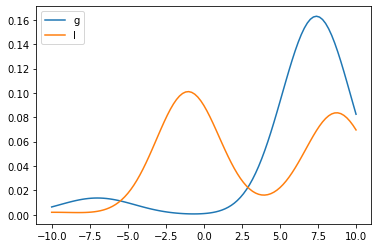

-0.3043721490948164
best trial is 1
[TRIAL: 0115]##########


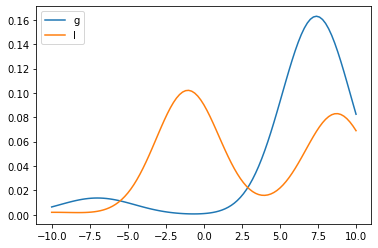

-0.14421553898675427
best trial is 1
[TRIAL: 0116]##########


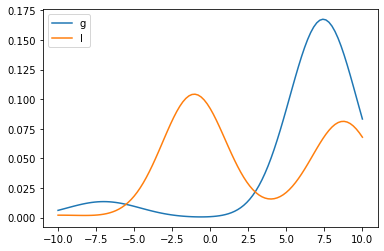

-0.11420173652166804
best trial is 1
[TRIAL: 0117]##########


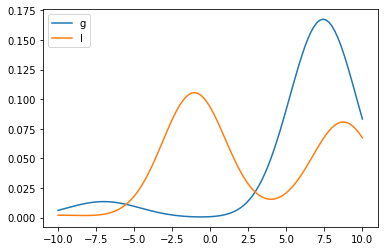

-0.12387961596209447
best trial is 1
[TRIAL: 0118]##########


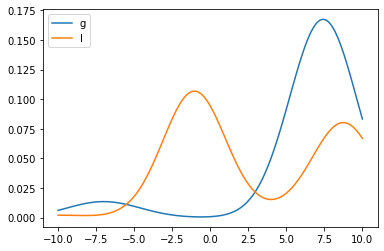

-0.11815921090362974
best trial is 1
[TRIAL: 0119]##########


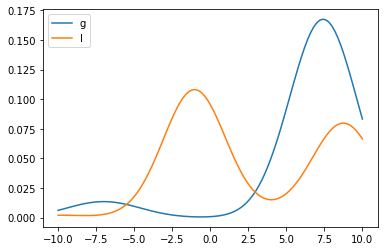

-0.058051196010625784
best trial is 1
[TRIAL: 0120]##########


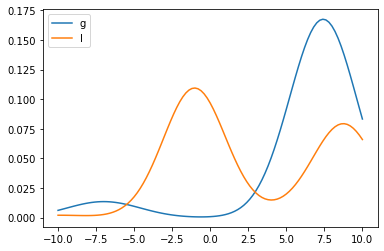

-0.12661202216716372
best trial is 1
[TRIAL: 0121]##########


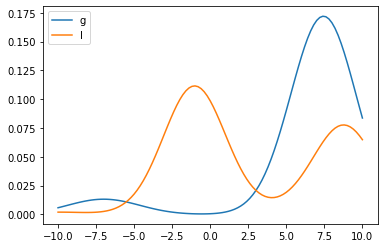

-0.6223412358605508
best trial is 1
[TRIAL: 0122]##########


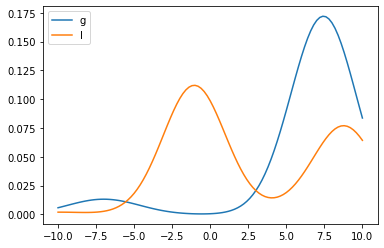

-0.056702125707723115
best trial is 1
[TRIAL: 0123]##########


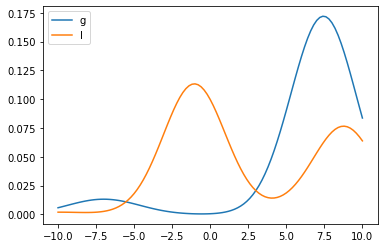

-0.10565582242855034
best trial is 1
[TRIAL: 0124]##########


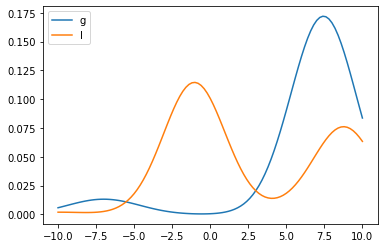

-0.15298759895392763
best trial is 1
[TRIAL: 0125]##########


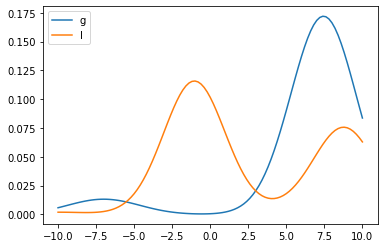

-0.12229742713447801
best trial is 1
[TRIAL: 0126]##########


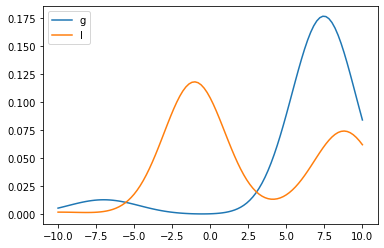

-0.032949081121394795
best trial is 1
[TRIAL: 0127]##########


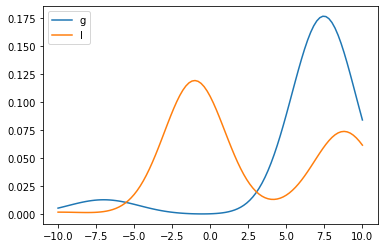

-0.0966726565683414
best trial is 1
[TRIAL: 0128]##########


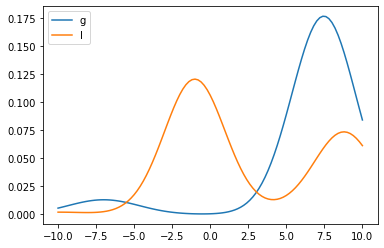

-0.10811313478608267
best trial is 1
[TRIAL: 0129]##########


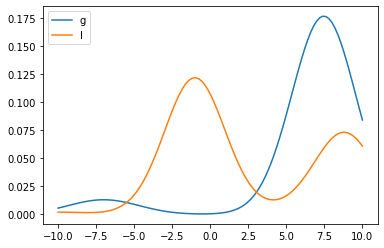

-0.055363553461840756
best trial is 1
[TRIAL: 0130]##########


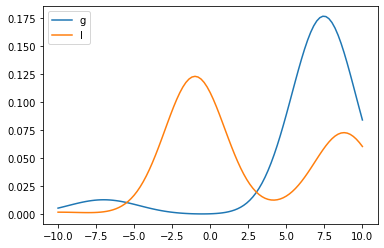

-0.09789921466368084
best trial is 1
[TRIAL: 0131]##########


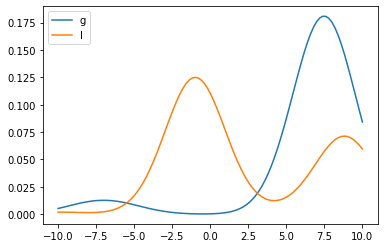

-0.10328473794380824
best trial is 1
[TRIAL: 0132]##########


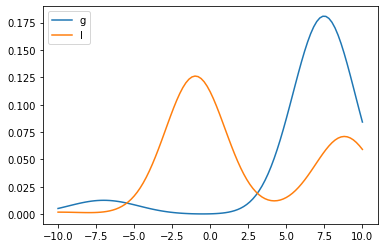

-0.2649709560089192
best trial is 1
[TRIAL: 0133]##########


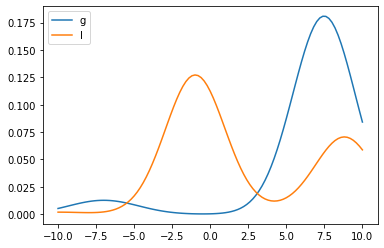

-0.1395033269799381
best trial is 1
[TRIAL: 0134]##########


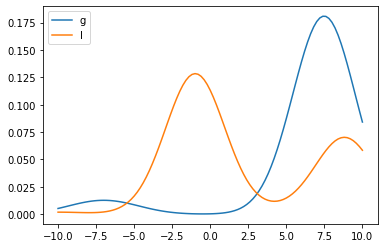

-0.03082655946417177
best trial is 1
[TRIAL: 0135]##########


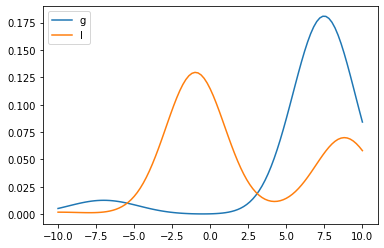

-0.06389595163634203
best trial is 1
[TRIAL: 0136]##########


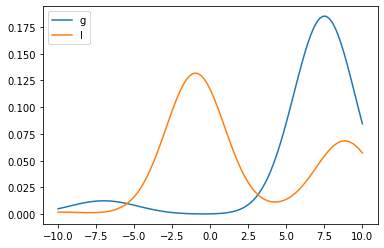

-0.18959121422114855
best trial is 1
[TRIAL: 0137]##########


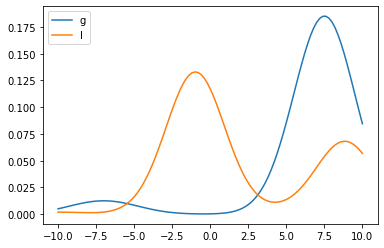

-0.07514852807537092
best trial is 1
[TRIAL: 0138]##########


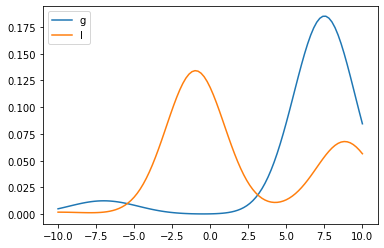

-0.05032671246507944
best trial is 1
[TRIAL: 0139]##########


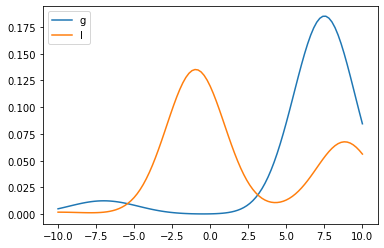

-0.016374148636137006
best trial is 1
[TRIAL: 0140]##########


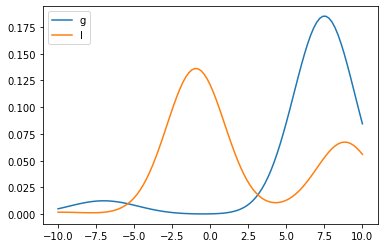

-0.027856512083528146
best trial is 1
[TRIAL: 0141]##########


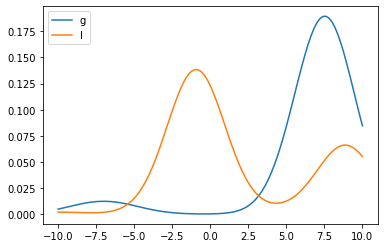

-0.10507552648832555
best trial is 1
[TRIAL: 0142]##########


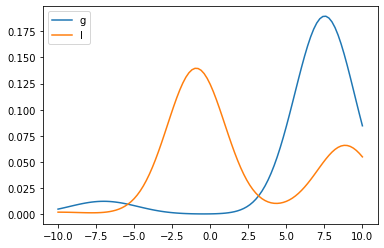

-0.09882277006304022
best trial is 1
[TRIAL: 0143]##########


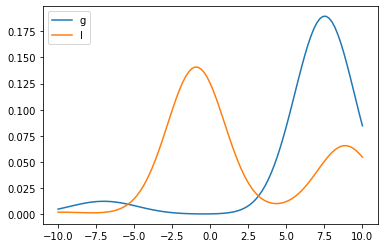

-0.030424391453341332
best trial is 1
[TRIAL: 0144]##########


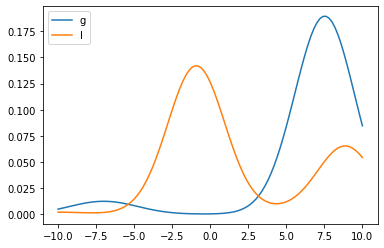

-0.06582390848756481
best trial is 1
[TRIAL: 0145]##########


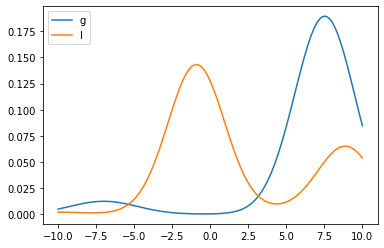

-0.10887408123002727
best trial is 1
[TRIAL: 0146]##########


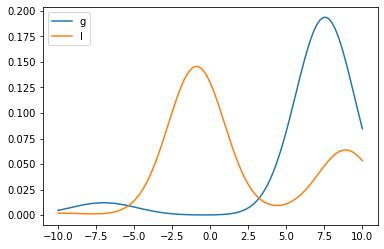

-0.03205245692061942
best trial is 1
[TRIAL: 0147]##########


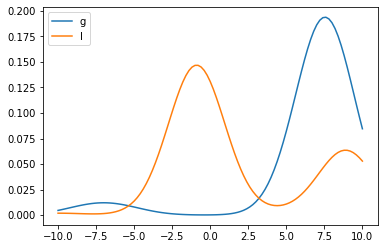

-0.08463718967607049
best trial is 1
[TRIAL: 0148]##########


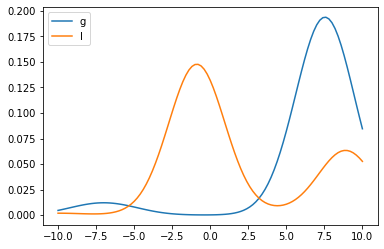

-0.0960625640994396
best trial is 1
[TRIAL: 0149]##########


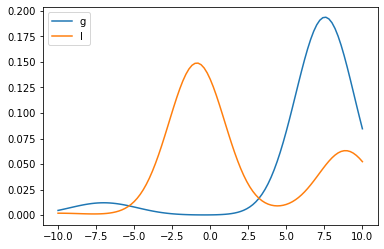

-0.042986789731002825
best trial is 1
[TRIAL: 0150]##########


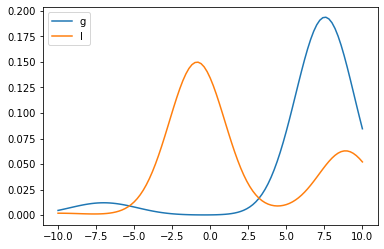

-0.08009943460969925
best trial is 1
[TRIAL: 0151]##########


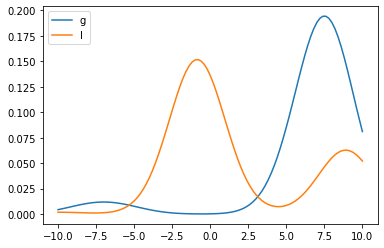

-0.06333719789275552
best trial is 1
[TRIAL: 0152]##########


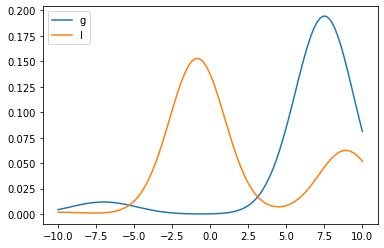

-0.12385996822162369
best trial is 1
[TRIAL: 0153]##########


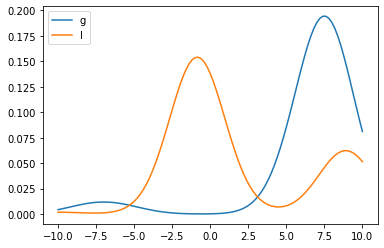

-0.0633647586780569
best trial is 1
[TRIAL: 0154]##########


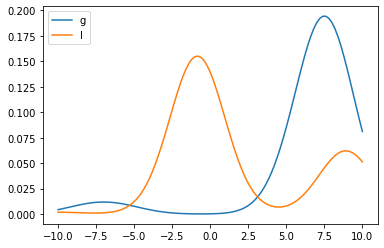

-0.05847421085950014
best trial is 1
[TRIAL: 0155]##########


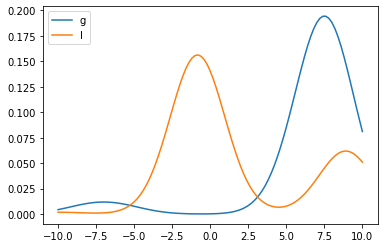

-0.009158263265620671
best trial is 1
[TRIAL: 0156]##########


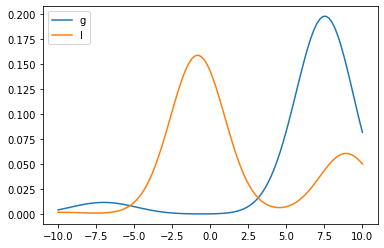

-0.10274313661620524
best trial is 1
[TRIAL: 0157]##########


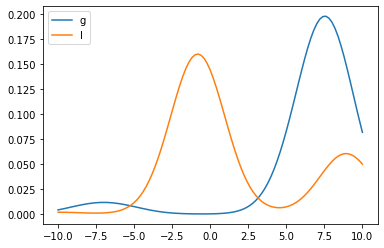

-0.16072521079185093
best trial is 1
[TRIAL: 0158]##########


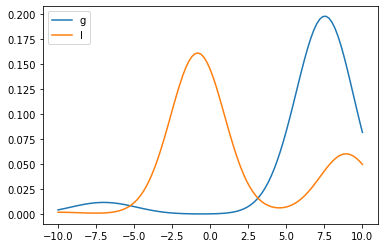

-0.08081643285184835
best trial is 1
[TRIAL: 0159]##########


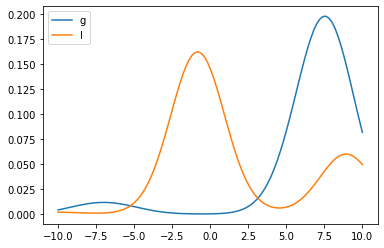

-0.058002215136291425
best trial is 1
[TRIAL: 0160]##########


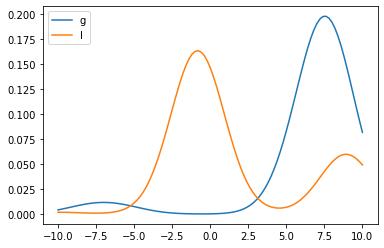

-0.05966725980023099
best trial is 1
[TRIAL: 0161]##########


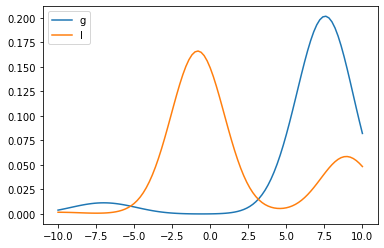

-0.06887273876875175
best trial is 1
[TRIAL: 0162]##########


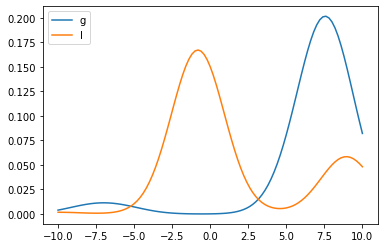

-0.27976185419179206
best trial is 1
[TRIAL: 0163]##########


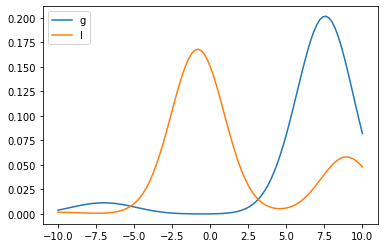

-0.08344686934847513
best trial is 1
[TRIAL: 0164]##########


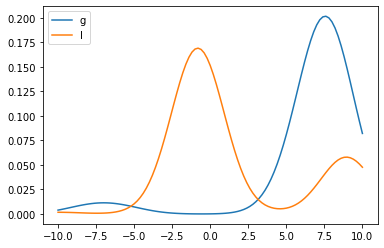

-0.029864100019270694
best trial is 1
[TRIAL: 0165]##########


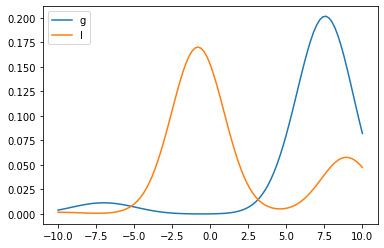

-0.1065256912156419
best trial is 1
[TRIAL: 0166]##########


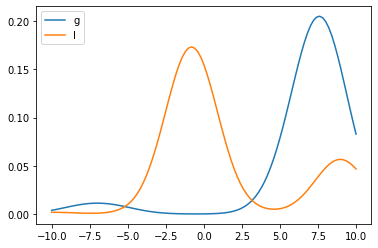

-0.037318430690186116
best trial is 1
[TRIAL: 0167]##########


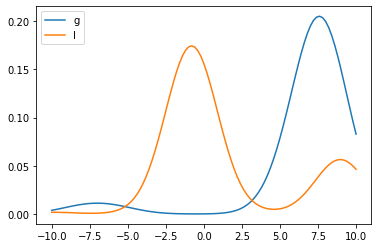

-0.09207776351824093
best trial is 1
[TRIAL: 0168]##########


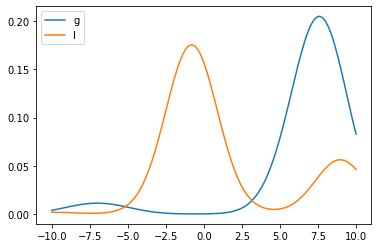

-0.1920681811641855
best trial is 1
[TRIAL: 0169]##########


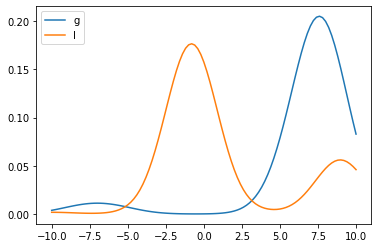

-0.11415457719413886
best trial is 1
[TRIAL: 0170]##########


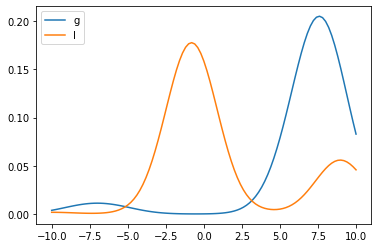

-0.02136832403881618
best trial is 1
[TRIAL: 0171]##########


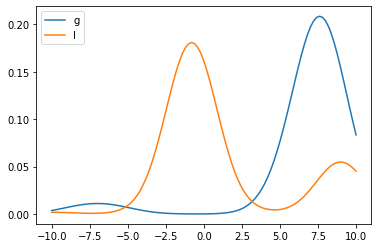

-0.043474935570996354
best trial is 1
[TRIAL: 0172]##########


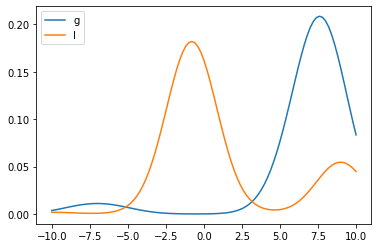

-0.03295811716107847
best trial is 1
[TRIAL: 0173]##########


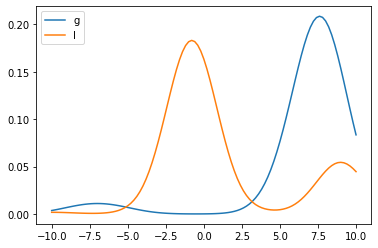

-0.12581956390243704
best trial is 1
[TRIAL: 0174]##########


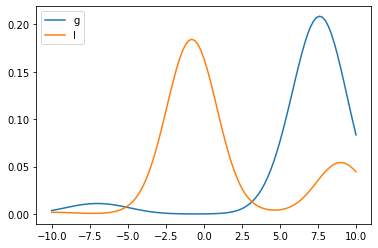

-0.19938466686903272
best trial is 1
[TRIAL: 0175]##########


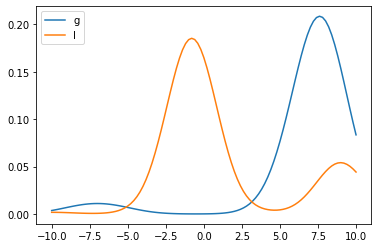

-0.04712363777465844
best trial is 1
[TRIAL: 0176]##########


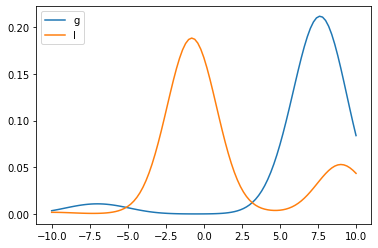

-0.09260524399813902
best trial is 1
[TRIAL: 0177]##########


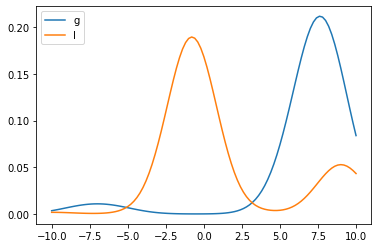

-0.09836211013915697
best trial is 1
[TRIAL: 0178]##########


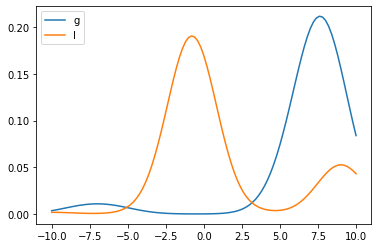

-0.13515245353793942
best trial is 1
[TRIAL: 0179]##########


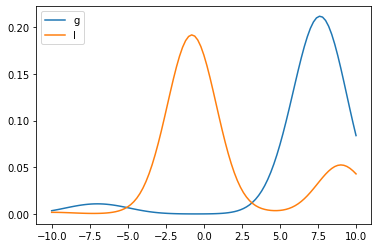

-0.14317809219143487
best trial is 1
[TRIAL: 0180]##########


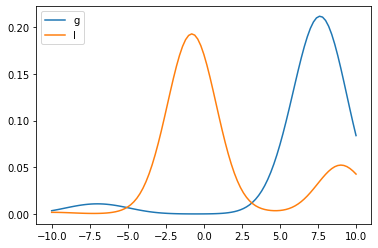

-0.031061228832955208
best trial is 1
[TRIAL: 0181]##########


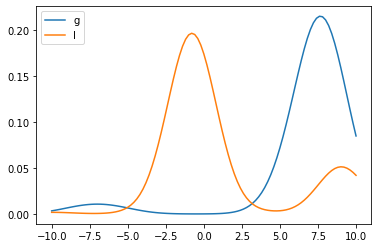

-0.0107447689110966
best trial is 1
[TRIAL: 0182]##########


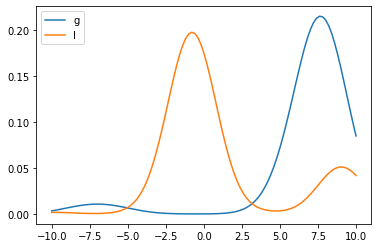

-0.1448419354688639
best trial is 1
[TRIAL: 0183]##########


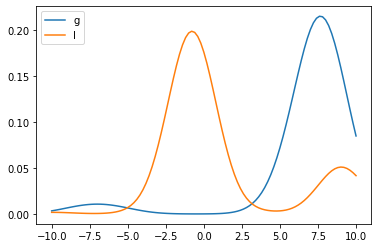

-0.1944505764326416
best trial is 1
[TRIAL: 0184]##########


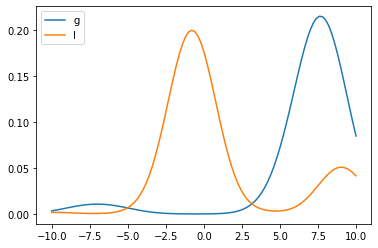

-0.08440539711265066
best trial is 1
[TRIAL: 0185]##########


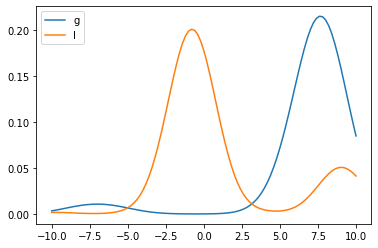

-0.07032578664465966
best trial is 1
[TRIAL: 0186]##########


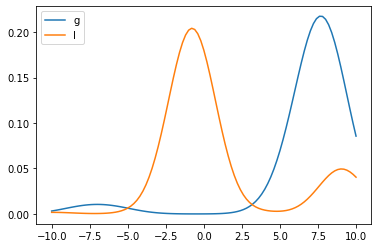

-0.1705579375829471
best trial is 1
[TRIAL: 0187]##########


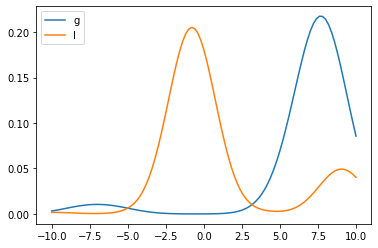

-0.08781153901805948
best trial is 1
[TRIAL: 0188]##########


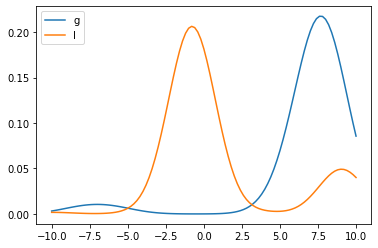

-0.23040636498509587
best trial is 1
[TRIAL: 0189]##########


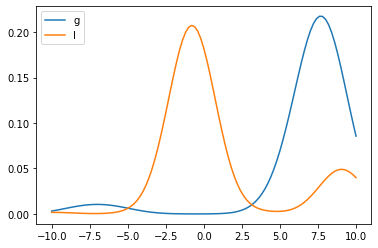

-0.30751358330372275
best trial is 1
[TRIAL: 0190]##########


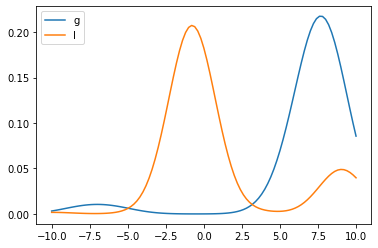

-0.07813049387935259
best trial is 1


In [53]:
np.random.seed(seed=SEED)

x_init = np.array([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8])
y_init = BBF(x_init)
print(x_init)

tpe_params = {
    "data_x" : x_init, 
    "data_y": y_init,
    "gamma": GAMMA,
    "seed": SEED,
    "n_trial": N_LOOP,
    "n_suggest": N_SUGGEST,
    "kernel": KERNEL,
    "objective": objective,
}

tpe = TPE(**tpe_params)
tpe.search()

## Reference
[1] https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf  
[2] http://ibis.t.u-tokyo.ac.jp/suzuki/lecture/2015/dataanalysis/L9.pdf  
[3]